In [1]:
if (!require('devtools')) install.packages('devtools')
devtools::install_github('behavioral-ds/evently')

Loading required package: devtools

Loading required package: usethis




✔  checking for file ‘/tmp/Rtmph0aYNM/remotes223e0ecb3e/behavioral-ds-evently-9be4daa/DESCRIPTION’ (453ms)
─  preparing ‘evently’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘evently_0.3.0.tar.gz’
   


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
library(evently)
setup_ampl("/root/ampl")


********************************************************

  This package requires AMPL and ipopt

  But they are not in your PATH environment.

  Please specify its binary folder path in ~/.Renviron

  Please also make sure the ipopt binary is in the 

  same folder.

********************************************************


It seems AMPL is not found in your PATH environment, do you want to install it now?

Warning message in fun(libname, pkgname):
“AMPL is missing! You might not be able to fit models.”


# Wczytanie danych

Użyty został zbiór danych Sina Weibo (https://paperswithcode.com/dataset/weibo), który zawiera dane dotyczące tweetów i ich retweetów zebranych 1 czerwca 2016 roku. Każdy rekord danych zawiera informacje dotyczącą id tweeta, id użytkownika będącego autorem tweeta, czas publikacji, ilość retweetów oraz czasy każdego z retweetów (ilość sekund od tweeta).

In [3]:
set.seed(13)

weibo <- read.csv("../input/simple-weibo/weibo_dataset.csv")

In [4]:
head(weibo, 2)

,message_id,root_user_id,publish_time,retweet_number,retweets
,<int>,<int>,<int>,<int>,<chr>
1,1,1,1464710400,41,"22032,30685,32169,34580,29372,16459,11292,22293,6970,5530,2822,12772,1019,3360,21422,1333,1643,1518,669,2191,207,2880,445,23626,2514,681,2038,4815,99,2329,884,243,1931,236,908,7108,1501,1287,549,376"
2,2,42,1464710401,42,"41171,46428,30719,30999,23192,33795,22745,447,16886,224,150,356,41,8,3842,90,454,1425,1280,2373,429,4673,229,2972,67,1204,224,624,395,381,1545,1391,1073,262,3800,5591,760,739,121,260,91"


In [5]:
cat("Zbiór posiada",dim(weibo)[1], "rekordów (tweetów) \n", sep = ' ')
cat("Każdy z rekordów scharakteryzowany jest za pomocą",dim(weibo)[2], "informacji: ", colnames(weibo) ,sep = ' ')

Zbiór posiada 119306 rekordów (tweetów) 
Każdy z rekordów scharakteryzowany jest za pomocą 5 informacji:  message_id root_user_id publish_time retweet_number retweets

Zbiór ten nadaje się do modelowania procesem Hawkesa, ponieważ zawiera informacje czasowe każdego retweeta. Dzięki temu możliwe jest dopasowanie serii do takich danych i późniejsze wykorzystanie np. do analizy popularności konkretnego tweeta. Pojawienie się nowego retweeta powoduje zwiększenie szansy na kolejny retweet, zatem spełniona jest cecha samo ekscytacji zdarzeń. Ograniczony czas danych (24 godziny od pojawienia się tweeta) sprawia, że ilość danych jest ograniczona i może nie być możliwe przewidzenie końcowego rozmiaru kaskady.

Surowy zbiór danych został sparsowany przy wykorzystaniu napisanego skryptu `parse_weibo.py`, który umożliwił przedstawienie danych (tweeta i jego retweetów) w odpowiedniej do tego zadania formie - czyli każdy wiersz zawiera informacje o jednym tweecie (jego autorze, czasie) oraz o czasach wszystkich jego retweetów (jako unixowy timestamp od pierwotnego tweeta).

# Wybór kaskad

Do wyboru kaskad napisano funkcje umożliwiającą wybór pojedyńczej kaskady za pomocą id tweeta (od 1 do 119306) oraz funkcję pomocniczą pozwalającą przeszukiwać użytkowników w oparciu o dopasowywanie do nich modelu i liczenie branching factor (starano się wybrać użykowników dla których branching factor był mniejszy niż 1).

In [6]:
extract_cascade <- function(data, id){
    one_cascade_data = data[id,]
    time = as.numeric(list(strsplit(as.character(one_cascade_data["retweets"]), ",")[[1]])[[1]])
    time = sort(time) / 3600
    magnitude = rep(1, length(time))
    cascade = data.frame(magnitude, time)
    cascade <- rbind(c(1,0), cascade)
    return (cascade)
}

In [42]:
find_user <- function() {
    for (id in 1000:1010) {
        cat("check user:", c(id), "\n")
        flush.console()
        
        user = extract_cascade(weibo, id)
        train_history <- user[with(user, time <= 12),]

        fitted_model = fit_series(train_history, model_type = 'EXP', observation_time = max(train_history$time), cores = 2)
        factor = get_branching_factor(fitted_model)

        if (factor < 1) {
            cat("factor:", c(factor), "for user:", c(id), "\n")
            flush.console()
        }
    }
}

find_user()

check user: 1000 
check user: 1001 
check user: 1002 
check user: 1003 
check user: 1004 
check user: 1005 
factor: 0.999999 for user: 1005 
check user: 1006 
check user: 1007 
check user: 1008 
factor: 0.999998 for user: 1008 
check user: 1009 
check user: 1010 


In [43]:
cascade1 = extract_cascade(weibo, 1005)
cascade2 = extract_cascade(weibo, 1008)

head(cascade1)
tail(cascade2)

,magnitude,time
,<dbl>,<dbl>
1,1,0.00000000
2,1,0.02000000
3,1,0.02388889
4,1,0.03416667
5,1,0.18722222
6,1,0.22861111


,magnitude,time
,<dbl>,<dbl>
7,1,0.3375000
8,1,0.3405556
9,1,0.3805556
10,1,0.4947222
11,1,0.7394444
12,1,7.7511111


# Dopasowanie parametrów i porównanie kaskad

In [44]:
fitted_model1 = fit_series(cascade1, model_type = 'EXP', observation_time = max(cascade1$time), cores = 2)
fitted_model1

- Model: EXP 
- No. of cascades: 1 
- init_par:
  K 1.16e+00; theta 1.51e+00
- par:
  K 1.00e+00; theta 4.26e-01
- Neg Log Likelihood: 17.4382 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 

In [45]:
fitted_model2 = fit_series(cascade2, model_type = 'EXP', observation_time = max(cascade2$time), cores = 2)
fitted_model2

- Model: EXP 
- No. of cascades: 1 
- init_par:
  K 1.78e+00; theta 1.22e+00
- par:
  K 1.00e+00; theta 1.19e+00
- Neg Log Likelihood: 2.62338 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 

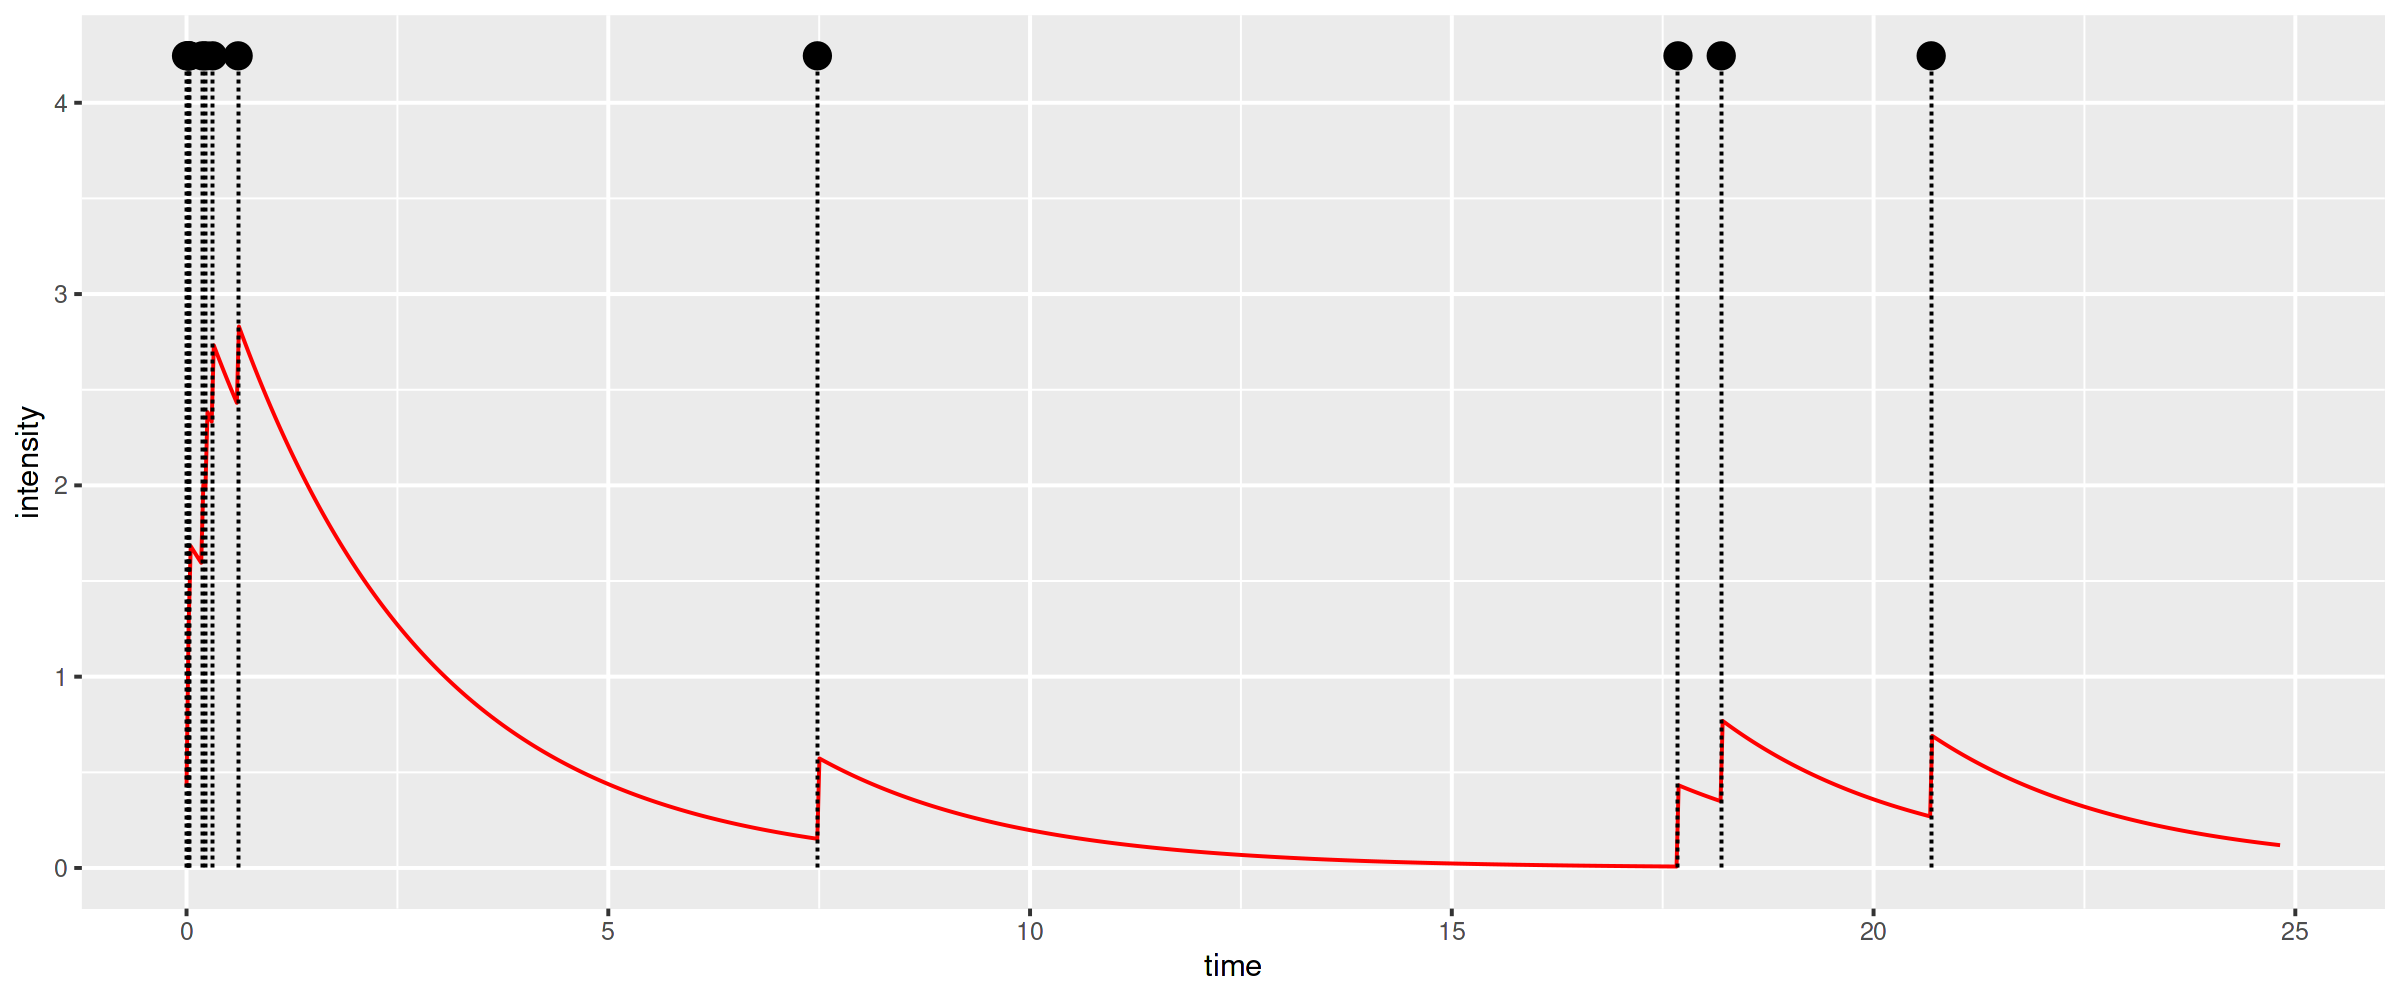

In [46]:
library(repr)
options(repr.plot.width=12, repr.plot.height=5, repr.plot.res = 200)
plot_event_series(fitted_model1)

Dla kaskady pierwszej widać, że w początkowym czasie po tweecie intensywność retweetów była większa, lecz retweety zdarzały się nawet w późniejszym czasie. Można wnioskować, że tweet ten był popularny stosunkowo dłużej.

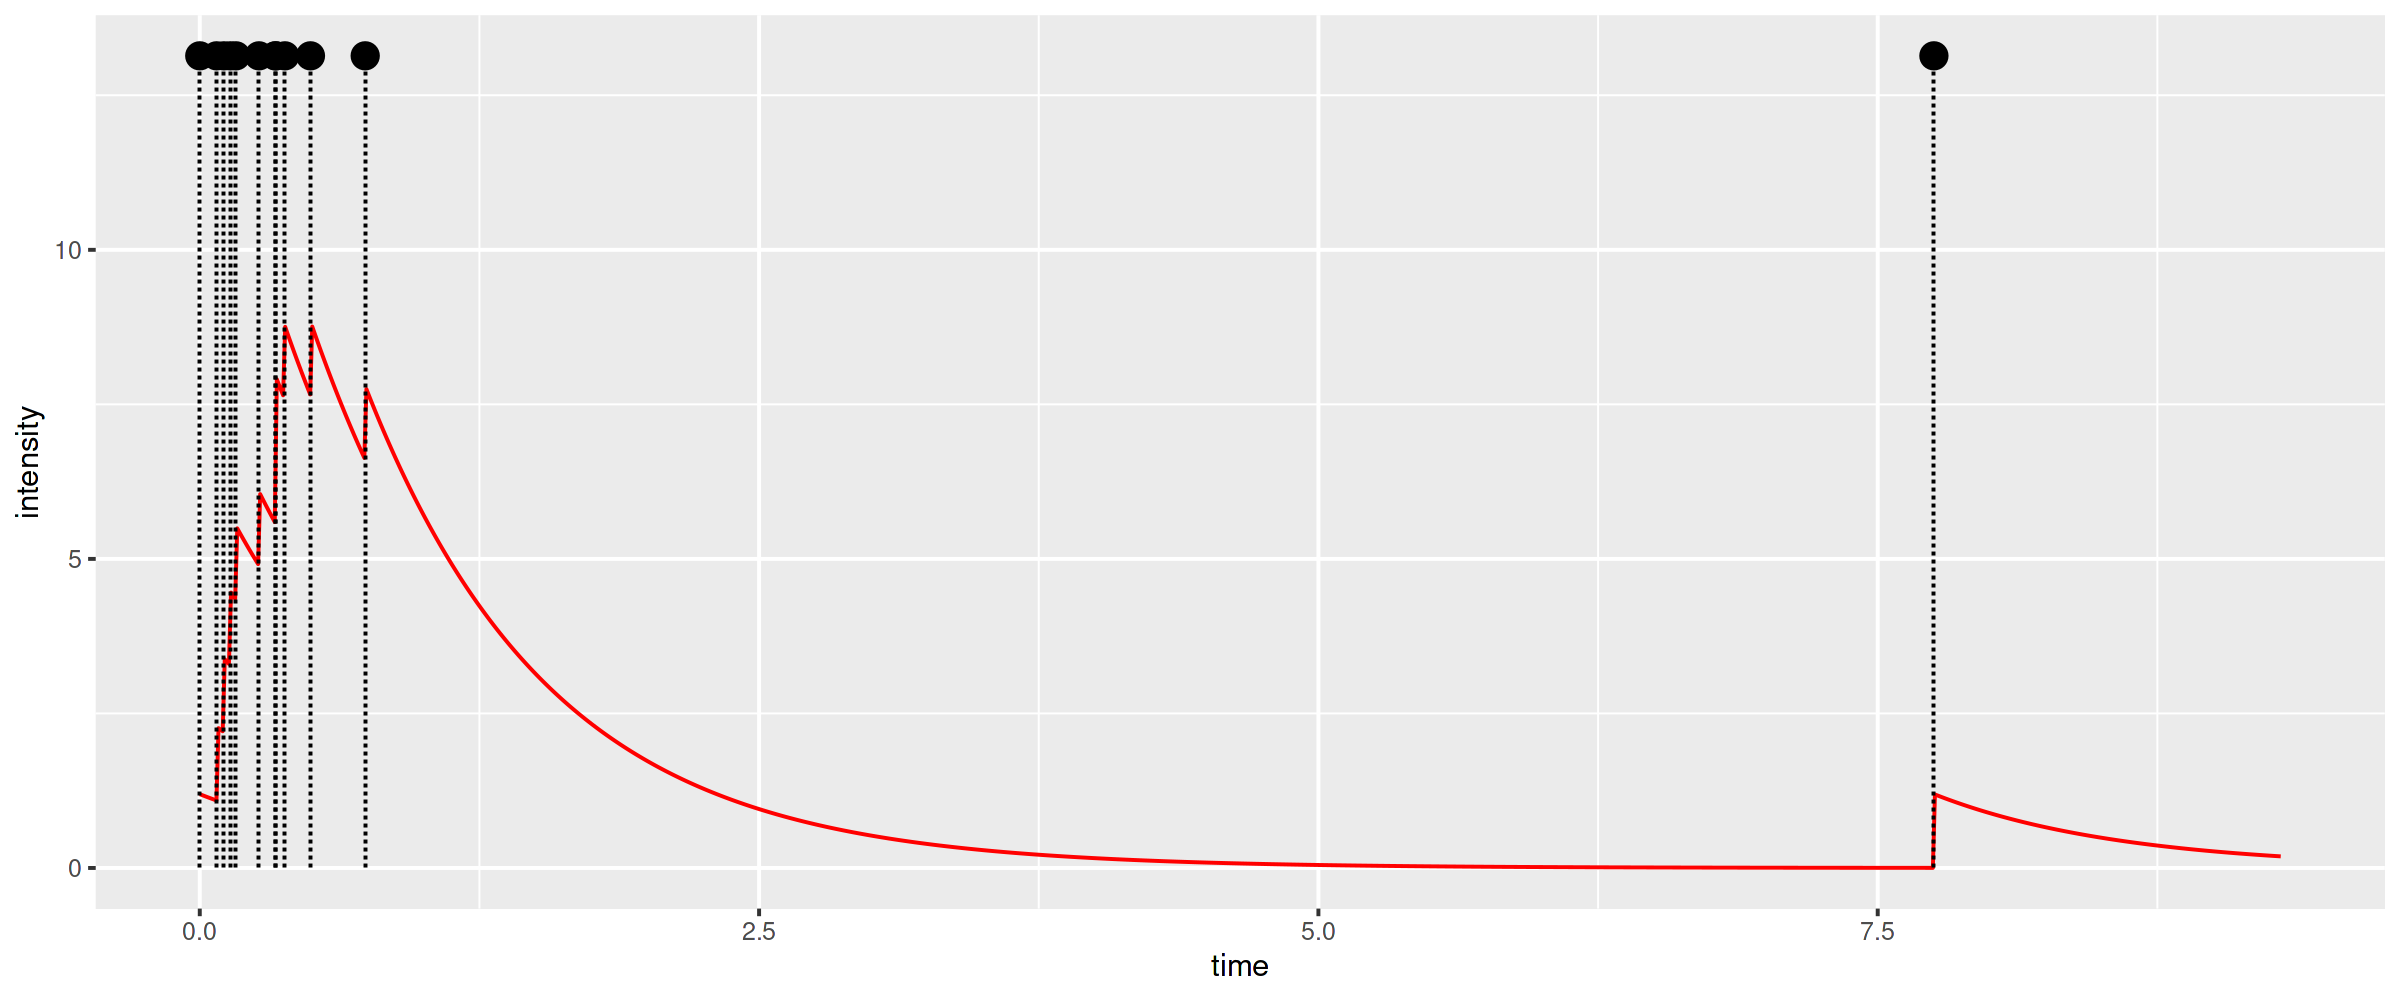

In [33]:
plot_event_series(fitted_model2)

W przypadku kaskady drugiej intensywność jest skupiona prawie tylko w pobliżu czasu 0 - znaczy to, że tweet ten cieszył się bardzo krótką popularnością i popularność ta szybko wygasła - już w czasie około 8 godzin od tweeta skończyły się jego retweety.

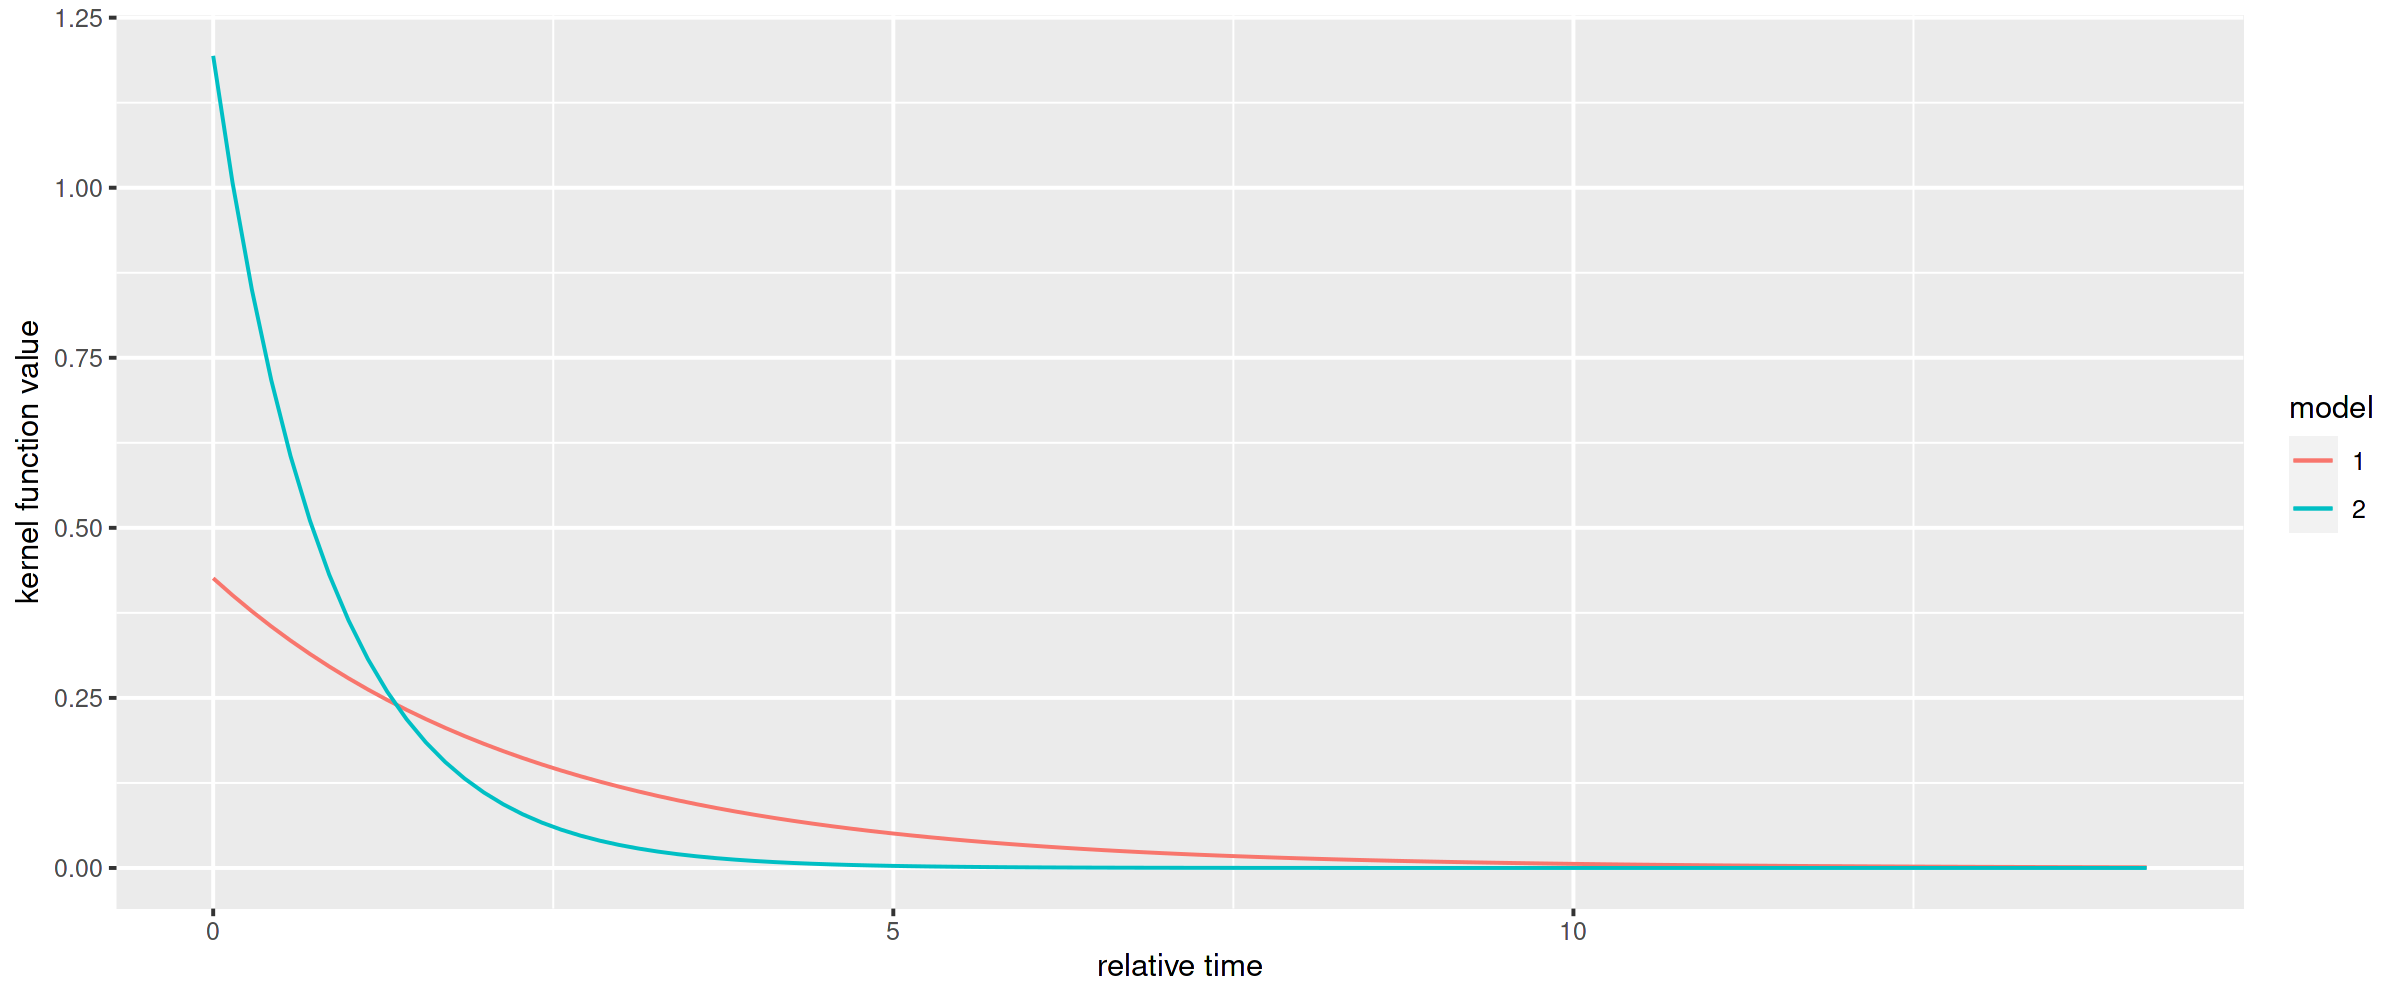

In [34]:
plot_kernel_function(list(fitted_model1, fitted_model2))

Wykres ten potwierdza wcześniej napisane wnioski - kaskada pierwsza (opisana na wykresie za pomocą serii model 1) trwa dłużej i dłużej wygasa, natomiast kaskada druga (model 2 na wykresie) jest bardzo liczna w krótkiej początkowej fazie i bardzo szybko wygasa. Widać tu wyraźną różnicę w popularności obu tweetów.

# Predykcja końcowego rozmiaru kaskady

In [35]:
library(dplyr)

Obie kaskady zostały ograniczone do początkowych dwunastu godzin, aby na tej podstawie spróbować estymować finalną wielkość kaskady.

In [47]:
train_history1 <- cascade1[with(cascade1, time <= 12),]
train_history2 <- cascade2[with(cascade2, time <= 12),]

In [48]:
fitted_history1 <- fit_series(train_history1, model_type = 'EXP', observation_time = max(train_history1$time))
fitted_history1

- Model: EXP 
- No. of cascades: 1 
- init_par:
  K 1.81e+00; theta 1.08e+00
- par:
  K 1.00e+00; theta 9.51e-01
- Neg Log Likelihood: 5.7686 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 

In [49]:
fitted_history2 <- fit_series(train_history2, model_type = 'EXP', observation_time = max(train_history2$time))
fitted_history2

- Model: EXP 
- No. of cascades: 1 
- init_par:
  K 2.68e-01; theta 2.57e+00
- par:
  K 1.00e+00; theta 1.19e+00
- Neg Log Likelihood: 2.62338 
- lower_bound:
  K 1.00e-100; theta 1.00e-100
- upper_bound:
  K 1.00e+04; theta 3.00e+02
- Convergence: 0 

In [52]:
branching1 = get_branching_factor(fitted_history1)
popularity1 = predict_final_popularity(fitted_history1)
cat("Branching factor dla pierwszej kaskady:", c(branching1),", oraz przewidziany końcowy rozmiar kaskady:", c(popularity1), "\n")

branching2 = get_branching_factor(fitted_history2)
popularity2 = predict_final_popularity(fitted_history2)
cat("Branching factor dla drugiej kaskady:", c(branching2),", oraz przewidziany końcowy rozmiar kaskady:", c(popularity2), "\n")

Branching factor dla pierwszej kaskady: 0.999999 , oraz przewidziany końcowy rozmiar kaskady: 1007875 
Branching factor dla drugiej kaskady: 0.999999 , oraz przewidziany końcowy rozmiar kaskady: 1001522 


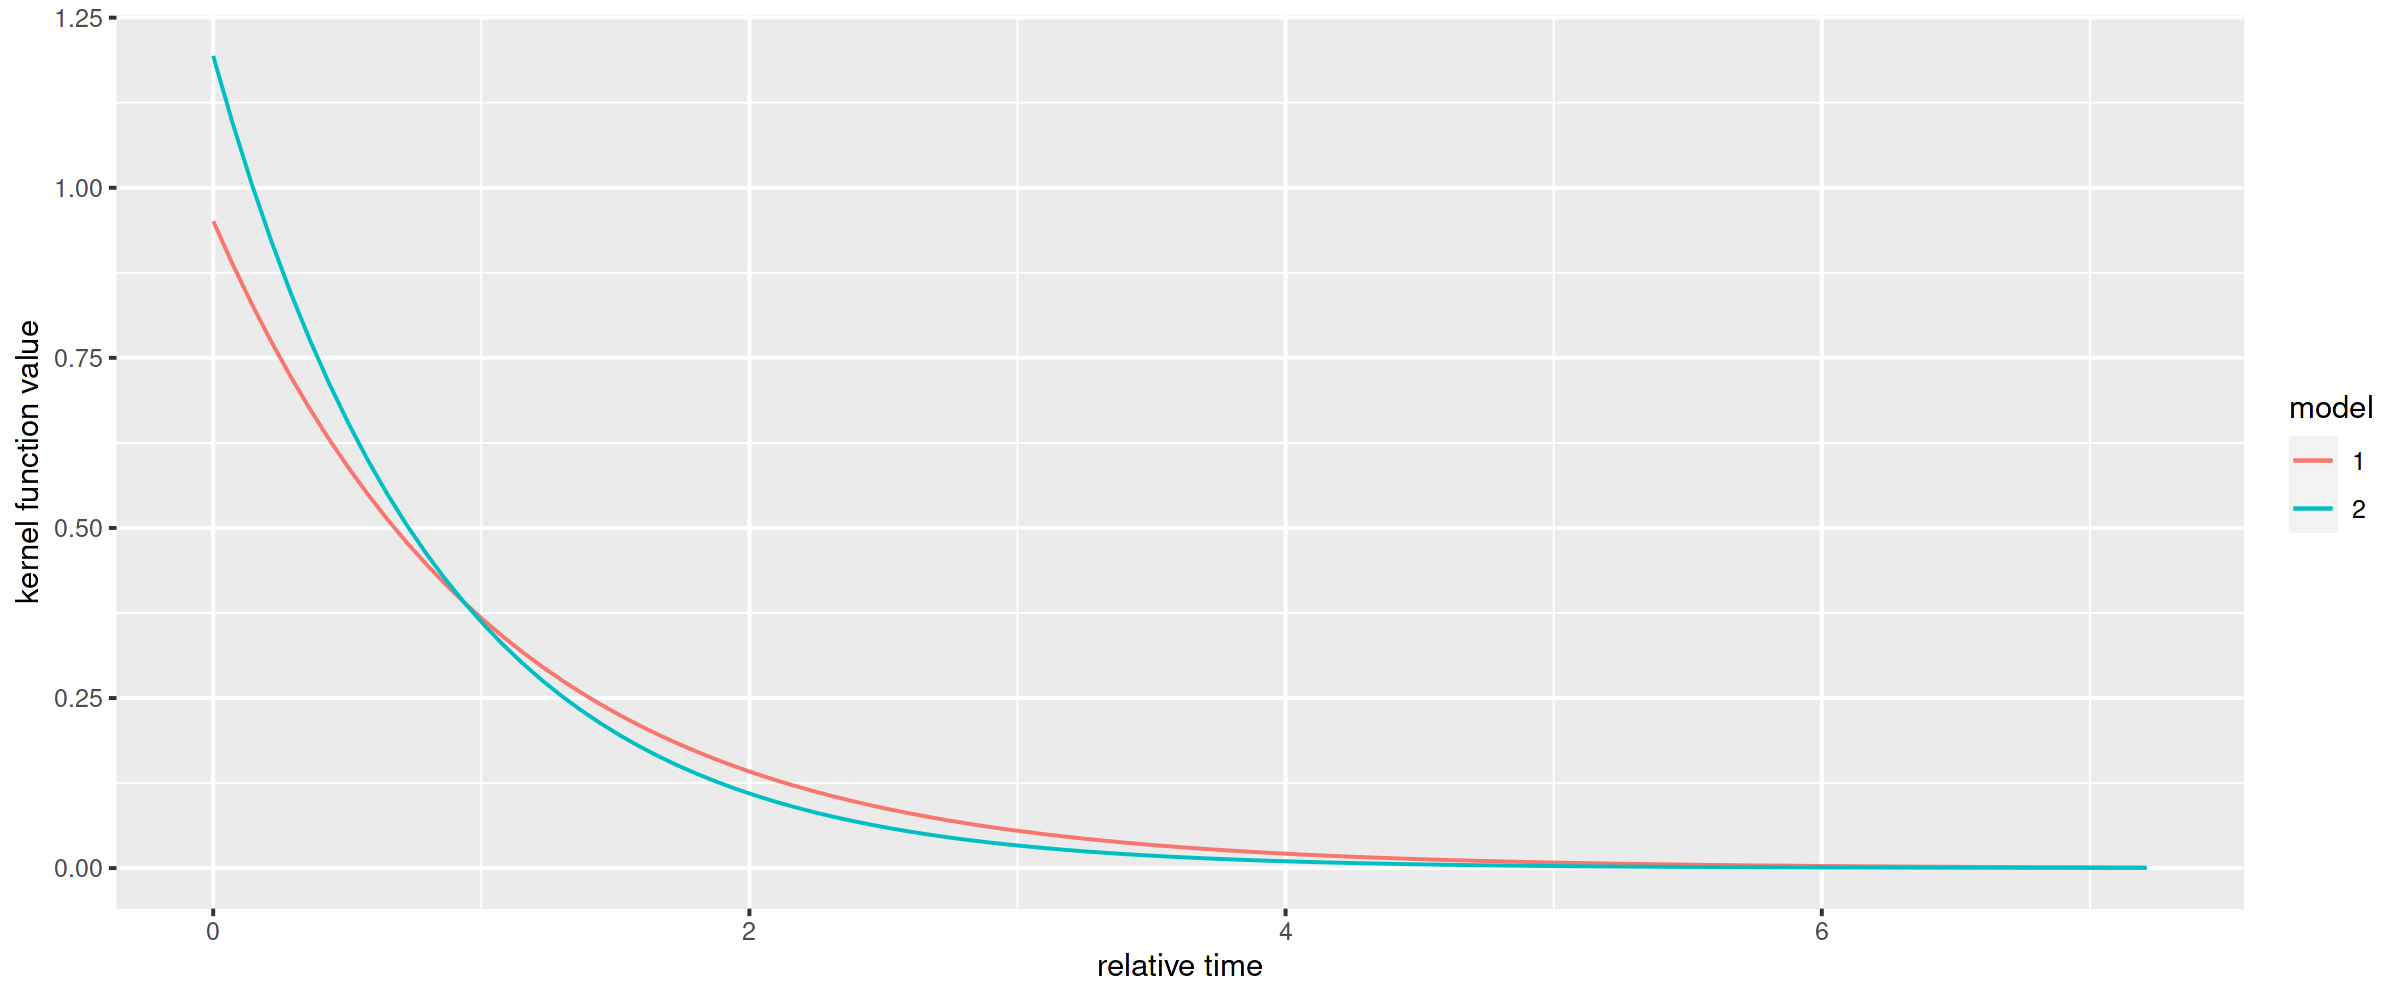

In [53]:
plot_kernel_function(list(fitted_history1, fitted_history2))

Mając do dyspozycji tylko dwanaście pierwszych godzin po tweecie, do obu kaskad dopasowały się podobne modele i zniknęła informacja o krótszej popularności kaskady 2. Branching factor dla obu kaskad wyszedł bliski 1, dlatego przewidziana końcowa popularność tweeta wyszła o wiele większa niż oczekiwana. Możliwe, że przy większej ilości danych (np. dłuższym okresie czasowym) branching factor wyszedłby mniejszy i przewidziany końcowy rozmiar kaskady wyszedłby bardziej podobny do rzeczywistego. 